In [130]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.3/682.3 KB 31.1 MB/s eta 0:00:00


In [131]:
from typing import *
import numpy as np
import torch
import torch.nn.functional as F
import torch.distributions as D
from torch.distributions import MultivariateNormal as MNormal
from torch.distributions import Normal, Cauchy, Categorical, Beta, MixtureSameFamily, Independent

from torch.distributions.distribution import Distribution
from scipy.stats import gaussian_kde

from copy import deepcopy
from functools import partial
from tqdm.notebook import tqdm, trange

import ot

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme('talk', style="white")

In [25]:
N_CHAINS = 50
N_SAMPLES = 1000
BURN_IN = 50

PROJ_DIM1 = -2
PROJ_DIM2 = -1

# Beta-ULA

In [27]:
class MoG(object):
    """
    Mixture of Gaussians distribution.

    Args:
        locs - locations of mean parameters for each Gaussian
        covs - covariances for each Gaussian
    """
    def __init__(self, 
            locs: torch.FloatTensor, 
            covs: torch.FloatTensor, 
            weights: Optional[torch.FloatTensor]=None):
        self.n_comp = len(locs)
        self.locs = locs
        self.covs = covs
        self.weights = weights if weights is not None else \
            torch.ones(self.n_comp, device=locs.device)
        self.weights /= self.weights.sum()
        self.gaussians = [MNormal(loc, cov) for loc, cov in zip(locs, covs)]
        mix = Categorical(self.weights)
        comp = Independent(MNormal(locs, covs), 0)
        self.mog = MixtureSameFamily(mix, comp)

    def sample(self, size: torch.Size):
        return self.mog.sample(size)

    @property
    def dim(self) -> int:
        return self.locs.shape[-1]

    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return self.mog.log_prob(x)

    def plot_2d_countour(self, ax):
        rad = self.covs.max() **.5 * 5
        x = np.linspace(self.locs.min()-rad, self.locs.max()+rad, 100)
        y = np.linspace(self.locs.min()-rad, self.locs.max()+rad, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.FloatTensor(np.stack([X, Y], -1))

        proj_slice = [PROJ_DIM1, PROJ_DIM2]
        gaussians = [MNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(self.locs, self.covs)]
        log_ps = torch.stack([
            torch.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(self.weights, gaussians)
            ], dim=0)
        Z = torch.logsumexp(log_ps, dim=0).reshape(inp.shape[:-1])
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=10, 
                   alpha=1., cmap='inferno')

In [28]:
# some code for drawing

def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (series[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in series[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

def plot_result(chains, dist, chain_id=0):
    proj_slice = [PROJ_DIM1, PROJ_DIM2]
    proj_dim1 = dist.dim + PROJ_DIM1 + 1 if PROJ_DIM1 < 0 else PROJ_DIM1 + 1
    proj_dim2 = dist.dim + PROJ_DIM2 + 1 if PROJ_DIM2 < 0 else PROJ_DIM2 + 1

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    result = chains.reshape(-1, chains.shape[-1])
    dist.plot_2d_countour(axs[0,0])
    xmin, xmax = axs[0,0].get_xlim()
    ymin, ymax = axs[0,0].get_ylim()

    axs[0,0].scatter(*result[:, proj_slice].T, alpha=min(0.6, 1000./result.shape[0]), s=10)
    axs[0,0].set_title(f'{N_CHAINS} chains')

    kernel = gaussian_kde(result[:, proj_slice].T)
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde = np.reshape(kernel(positions).T, X.shape)
    axs[0,1].contour(X, Y, kde, cmap='inferno')
    axs[0,1].set_title(f'KDE')

    chain_id = 0
    result = chains[:, chain_id, :]
    dist.plot_2d_countour(axs[1,0])
    axs[1,0].scatter(*result[:, proj_slice].T, s = 10)
    axs[1,0].set_title(f'Trajectory of chain {chain_id}')

    if len(np.unique(result[:, proj_slice], axis=0)) > 0:
      try:
        kernel = gaussian_kde(np.unique(result[:, proj_slice], axis=0).T)
        x = np.linspace(xmin, xmax, 100)
        y = np.linspace(ymin, ymax, 100)
        X, Y = np.meshgrid(x, y)
        positions = np.vstack([X.ravel(), Y.ravel()])
        kde = np.reshape(kernel(positions).T, X.shape)
        axs[1,1].contour(X, Y, kde, cmap='inferno')
        axs[1,1].set_title(f'KDE')
      except np.linalg.LinAlgError:
        pass


    for i in range(2):
      for j in range(2):
        axs[i,j].set_xlim(xmin, xmax)
        axs[i,j].set_ylim(ymin, ymax)
        axs[i,j].set_xlabel(fr'$X{proj_dim1}$')
        axs[i,j].set_ylabel(fr'$X{proj_dim2}$')
        # ax.axis('square')

    fig.tight_layout()
    plt.show()

In [29]:
def ULA(start: torch.FloatTensor, 
        target, 
        n_samples: int,
        burn_in: int,
        step_size: float, 
        step_distr = None,
        verbose: bool=False) -> torch.FloatTensor:
    """
    Unadjusted Langevin Algorithm
    Args:
        start - strating points of shape [n_chains, dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim]
    """
    n_chains, dim = start.shape
    chains = torch.empty((n_samples, n_chains, dim))
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None

    range_ = trange if verbose else range

    for step_id in range_(n_samples+burn_in):
        log_prob = target.log_prob(x)
        grad = torch.autograd.grad(log_prob.sum(), x)[0]
        if step_distr is not None:
            cur_step = step_size * step_distr.sample((n_chains, 1))
        else:
            cur_step = step_size
        x = x + cur_step * grad + (2 * cur_step) ** .5 * torch.randn_like(x)
        if step_id >= burn_in:
            chains[step_id-burn_in] = x.detach().data.clone()
    return chains

In [30]:
a = torch.ones(5)
b = torch.arange(5).float()
a @ b

tensor(10.)

In [31]:
class MixtureOfBetas(Distribution):
    def __init__(self, alphas, betas, weights=None, validate_args=False):
        super().__init__()

        if weights is not None:
            self.weights = torch.as_tensor(weights).float()
        else:
            self.weights = torch.ones(len(alphas)).float()

        assert len(alphas) == len(betas) == len(self.weights)

        self.weights /= self.weights.sum() 
        self.Betas = [Beta(alphas[i], betas[i]) for i in range(len(self.weights))]
        self.Categ = Categorical(self.weights)
        self._alphas = torch.as_tensor(alphas)
        self._betas = torch.as_tensor(betas)
        self.expectation = self.weights @ (self._alphas / (self._alphas + self._betas))

    def cdf(self, value):
        res = torch.zeros_like(value)
        for i in range(len(self.weights)):
            res += self.weights[i] * self.Betas[i].cdf(value)
        return res
    
    def log_prob(self, value):
        res = torch.zeros_like(value)
        for i in range(len(self.weights)):
            res += self.weights[i] * torch.exp(self.Betas[i].log_prob(value))
        return res
        
    def sample(self, size):
        total = np.prod(np.asarray(size, dtype=int))
        idxs = self.Categ.sample((total,))
        res = torch.zeros(total)
        for i, beta_idx in enumerate(idxs):
            res[i] = self.Betas[beta_idx].sample()
        res = res.reshape(*size)
        return res

    @property
    def arg_constraints(self):
        return {}

In [32]:
# d = 100
# d_special = 10
# Gamma = torch.randn((d_special, d_special)) + d * torch.eye(d_special, d_special)/d_special
# precision = torch.eye(d, d)
# precision[:d_special, :d_special] += Gamma.T @ Gamma
# sigma = torch.linalg.inv(precision)
# mu = torch.zeros(d)

# target = MNormal(mu, sigma)

In [33]:
# @torch.inference_mode()
# def get_errors(x, mu=mu, sigma=sigma):
#     n_chains = x.shape[1]
#     preds = torch.einsum('SCi,SCj->Sij', x, x) / n_chains
#     true = sigma + mu[:,None] * mu[None,:]
#     diff = preds - true[:,...]
#     return torch.linalg.norm(diff, ord=2, dim=(1, 2))

In [349]:
@torch.inference_mode()
def plot_distribution(distr: D.distribution, name=None, left=-5, right=5, N=1000):
    plt.figure(figsize=(6, 4))
    if name is None:
        name = f"D: {distr}, mean={round(distr.mean.item(), 1)}"
    plt.title(name)

    sup = distr.support
    if hasattr(sup, "lower_bound"):
        left = max(left, sup.lower_bound)
    if hasattr(sup, "upper_bound"):
        right = min(right, sup.upper_bound)
    
    if sup.is_discrete:
        x = torch.arange(left, right+1, dtype=int)
        probs = torch.exp(distr.log_prob(x))
        plt.bar(x, probs)
        return
    x = torch.linspace(left, right, N)
    probs = torch.exp(distr.log_prob(x))
    plt.plot(x, probs)

In [35]:
def random_ULA(distr: D.distribution,
               start: torch.FloatTensor,
               target,
               name=None,
               n_samples: int=N_SAMPLES,
               burn_in:   int=BURN_IN,
               step_size: float=1.0,
               verbose:   bool=True):
    if verbose:
        plot_distribution(distr)
    step_size /= distr.mean.item()
    sampled_chain = ULA(start, target, n_samples, burn_in, step_size=step_size, step_distr=distr, verbose=verbose)
    return sampled_chain

## Metrics

In [36]:
# def row_count_unique(input):
#     input += 1 + input.min()
#     unique = torch.sort(input)[0]
#     duplicates = unique[:,  1:] == unique[:, :-1]
#     unique[:, 1:][duplicates] = 0
#     count_matrix = torch.zeros(input.nelement(), dtype=torch.long)
#     idxs = torch.nonzero(unique.view(-1), as_tuple=True)[0]
#     counts = torch.diff(idxs)
#     count_matrix[idxs[:-1]] = counts
#     count_matrix[idxs[-1]] = input.nelement() - idxs[-1]
#     return count_matrix.reshape(input.shape)

In [37]:
def get_modes_coverage(chains, locs, sigma, k_threshold=5):
    '''
        args:
            chains: torch.Tensor[n_samples, n_chains, dim] - sampled chains
            locs: torch.Tensor[N_Mixtures, dim] - centers of gaussians
            sigma: int - sigma of all gaussians (assume they have diagonal cov)
            k_threshold: int - minimum number of points from chain near center of gaussian to consider it covered
    
        returns:
            n_covered: torch.tensor[n_chains] -- number of covered modes for each chain
    '''
    n_samples, n_chains, dim = chains.shape
    chains = chains.clone().transpose(0, 1).reshape(n_chains, n_samples, 1, dim)
    dists = torch.linalg.norm(chains - locs.view(1, 1, -1, dim), dim=-1, ord=2)
    # dists: torch.Tensor[n_chains, n_samples, N_mixtures] -- distances to modes
    mode_idxs = dists.argmin(dim=-1)
    close_ind = torch.amin(dists, dim=-1) <= 2*sigma*np.sqrt(dim)
    results = np.zeros(n_chains)
    for i in range(n_chains):
        _, counts = torch.unique(mode_idxs[i][close_ind[i]], return_counts=True)
        results[i] = torch.sum(counts >= k_threshold)
    return results

In [128]:
def sliced_TV(chain, reference, n_proj=20, min=-15, max=15, grid_size=1000):
    '''
        args:
            chain: torch.Tensor[n_samples, dim] - sampled chains
            reference: torch.Tensor[n_samples, dim] - reference sample from true distribution
    
        returns:
            ess: -- effective sample size averaged over dimensions
    '''
    chain = np.asarray(chain)
    reference = np.asarray(reference)
    n_samples, dim = chain.shape
    vecs = np.random.randn(dim, n_proj)
    vecs /= np.linalg.norm(vecs, ord=2, axis=1, keepdims=True)

    chain_proj = chain @ vecs
    ref_proj = reference @ vecs

    grid = np.linspace(min, max, grid_size)
    res = 0
    for i in range(n_proj):
        chain_kde = gaussian_kde(chain_proj[:,i])
        ref_kde   = gaussian_kde(ref_proj[:,i])
        res += np.abs(chain_kde(grid) - ref_kde(grid)).mean()
    return res * (max-min) / (2*n_proj)

In [39]:
a = torch.randn(1000, 20)
b = torch.randn(1000, 20)
sliced_TV(torch.randn(1000, 20), torch.randn(1000, 20))

0.03623614610597102

In [307]:
@torch.inference_mode()
def calc_ess(chains):
    '''
        Computes Effective Sample Size for generated markov chains
        see http://www.stat.columbia.edu/~gelman/book/BDA3.pdf
        args:
            chains: torch.Tensor[n_samples, n_chains, dim] - sampled chains
    
        returns:
            ess: -- effective sample size coefficient averaged over dimensions
    '''
    n_samples, n_chains, dim = chains.shape
    chains = chains.transpose(0, 2) # dim, n_chains, n_samples

    means = chains.mean(dim=(1,2), keepdim=True)
    corr = 0
    # within-sequence
    W = torch.mean((chains - chains.mean(dim=2, keepdim=True))**2, dim=(1,2))
    # between-sequence
    B = torch.sum((chains.mean(dim=2, keepdim=True) - means)**2, dim=(1,2)) / (n_chains-1)
    var = B + W

    corrs = torch.zeros((n_samples-1, dim))
    for k in range(1, n_samples):
        cur_corr = torch.mean((chains[:,:,k:] - chains[:,:,:-k])**2, dim=(1,2))
        # cur_corr = torch.mean(cur_corr*s, dim=1)
        corrs[k-1] = 1 - (0.5*cur_corr)/var
        if k > 1 and k % 2 == 1 and sum(corrs[k-1] + corrs[k-2]) < 0:
            corrs[k-1] = 0
            corrs[k-2] = 0
            break
    res = torch.mean(1 / (1 + 2*corrs.sum(dim=0)))
    return res.item()

In [306]:
calc_ess(torch.randn(1000, 100, 10))

3


1.001002550125122

In [290]:
torch.ones(5).numpy()

array([1., 1., 1., 1., 1.], dtype=float32)

In [186]:
def calc_emd(chain, reference):
    d = chain.shape[1]
    return ot.emd2([], [], ot.dist(reference.numpy(), chain.numpy())) / d

## Setting Up Experiments

First representative - mixture of Gaussians. Multimodal, simple geometry.

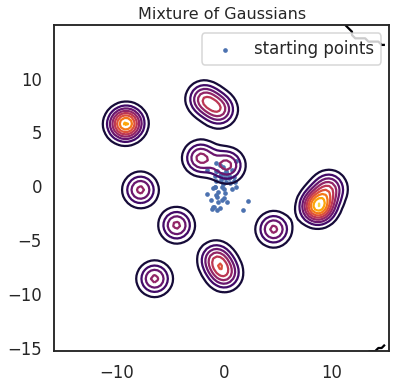

In [42]:
dim = 10
num_gaussians = 15
N_CHAINS = 50
N_SAMPLES = 1000
BURN_IN = 100
sigma = 1
x_max, x_min = 10, -10

coords = torch.meshgrid([torch.arange(3) for i in range(dim)])

locs = torch.rand(num_gaussians, dim) * (x_max - x_min) + x_min
# locs -= locs.mean(dim=1, keepdim=True)
locs = locs + torch.randn_like(locs) / np.sqrt(dim)

covs = sigma * torch.eye(dim)[None, ...].repeat(locs.shape[0], 1, 1).float()
weights = torch.ones(locs.shape[0])
mog = MoG(locs, covs, weights)

plt.figure(figsize=(6,6))
ax = plt.subplot()
mog.plot_2d_countour(ax)


start_mog = torch.randn((N_CHAINS, mog.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_mog[:, proj_slice].T, s=10, label='starting points')
plt.title('Mixture of Gaussians', fontsize=16)
plt.axis('equal')
plt.legend()
plt.show()

In [ ]:
reference = mog.sample(torch.tensor([N_SAMPLES]))
plot_result(reference.unsqueeze(1), mog)
calc_ess(reference.unsqueeze(1))

In [308]:
def run_exp(distr, name=None, step_size=1.5, start_mog=start_mog, tv_chains=10, verbose=False):
    chains = random_ULA(distr, start_mog, mog, name=None, step_size=step_size, verbose=verbose)
    tvs = [sliced_TV(reference, chains[i]) for i in range(tv_chains)]
    modes = get_modes_coverage(chains, locs, sigma).mean()
    ess = round(calc_ess(chains), 3)
    emd = [calc_emd(reference, chains[i]) for i in range(tv_chains)]
    if verbose:
        print('Modes covered:', modes, '/', num_gaussians)
        print('ESS:', ess)
        print(f'Sliced TV: {round(np.mean(tvs), 3)} ± {round(np.std(tvs), 3)}')
        print(f'EMD: {round(np.mean(emd), 32)} ± {round(np.std(emd), 2)}')
        plot_result(chains, mog)
    return modes, ess, round(np.mean(tvs), 3), round(np.mean(emd), 2)

In [187]:
run_exp(D.Binomial(probs=1), step_size=0.1, name="Beta (1,1)")

(1.0, 0.003, 0.504, 40.18)

In [188]:
run_exp(D.beta.Beta(1, 3), step_size=1.1, name="Beta (1,3)")

(7.36, 0.005, 0.217, 32.11)

In [64]:
D.Binomial(probs=1).mean

tensor(1.)

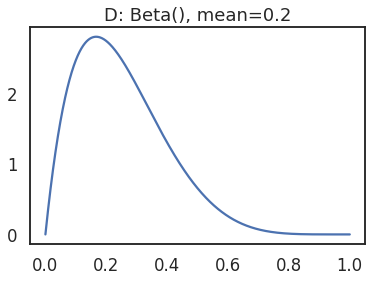

In [87]:
plot_distribution(D.beta.Beta(2, 6))

  0%|          | 0/1050 [00:00<?, ?it/s]

Modes covered: 10.98 / 15
ESS: 15
Sliced TV: 0.122 ± 0.01


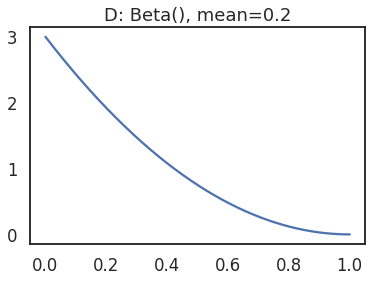

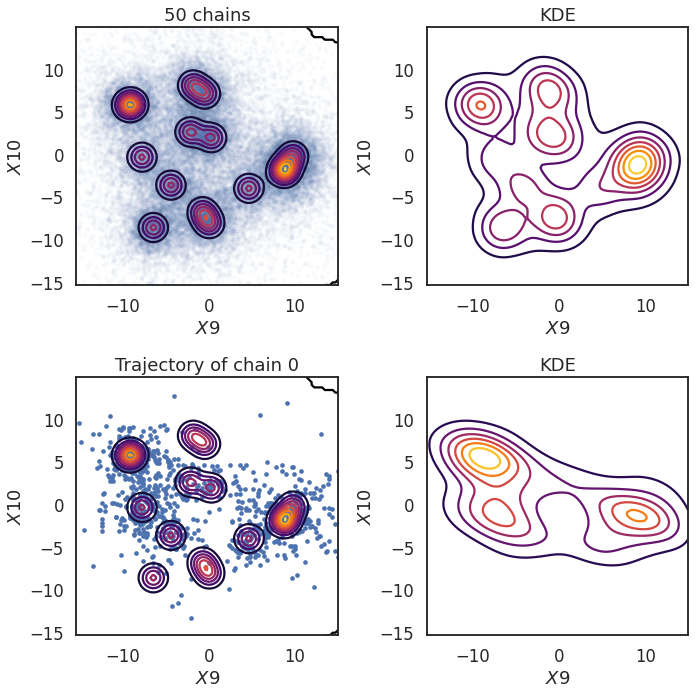

In [79]:
run_exp(D.beta.Beta(1, 3), step_size=1.25, name="Beta (1,1)", verbose=True);

In [ ]:
run_exp(D.Categorical(torch.tensor([0, 1])), verbose=True)

In [378]:
def folded_distr(base_distr : D.distribution.Distribution):
    transform = [D.transforms.AbsTransform()]
    return D.transformed_distribution.TransformedDistribution(base_distr, transform)

## Experiments

In [309]:
results = []

In [313]:
for step_size in np.linspace(0.1, 2, 20):
    modes, ess, tv, emd = run_exp(D.Binomial(probs=1), step_size=step_size, name="const")
    results.append({
        "distribution" : "const",
        "params" : "",
        "step_size" : step_size,
        "modes_covered" : modes,
        "ess": ess,
        "sliced_TV" : tv,
        "emd" : emd,
    })

In [314]:
result_df = pd.DataFrame.from_dict(results)
result_df

,distribution,params,step_size,modes_covered,ess,sliced_TV,emd
0,const,,0.1,1.00,0.010,0.503,40.21
1,const,,0.1,1.00,0.006,0.502,39.49
2,const,,0.2,1.00,0.008,0.515,40.30
3,const,,0.3,1.00,0.006,0.511,39.80
4,const,,0.4,1.00,0.008,0.495,40.16
5,const,,0.5,1.00,0.012,0.498,39.58
6,const,,0.6,1.00,0.006,0.490,39.36
7,const,,0.7,1.00,0.029,0.495,39.28
8,const,,0.8,1.00,0.013,0.471,39.41
9,const,,0.9,1.00,-0.030,0.480,39.22


In [315]:
for a in np.linspace(1, 3, 3):
    for b in np.linspace(1, 9, 5):
        for step_size in np.linspace(0.6, 1.6, 6):
            modes, ess, tv, emd = run_exp(D.beta.Beta(a, b), step_size=step_size, name="Beta")
            results.append({
                "distribution" : "Beta",
                "params" : f"a: {a}, b: {b}",
                "step_size" : step_size,
                "modes_covered" : modes,
                "ess": ess,
                "sliced_TV" : tv,
                "emd" : emd,
            })

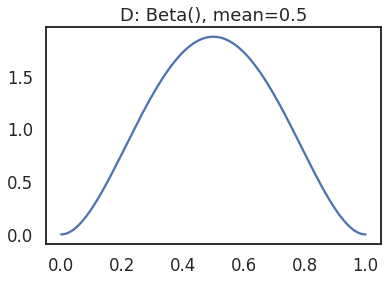

  0%|          | 0/1050 [00:00<?, ?it/s]

Modes covered: 8.8 / 15
ESS: 0.008
Sliced TV: 0.2 ± 0.017
EMD: 24.44937482864377 ± 0.78


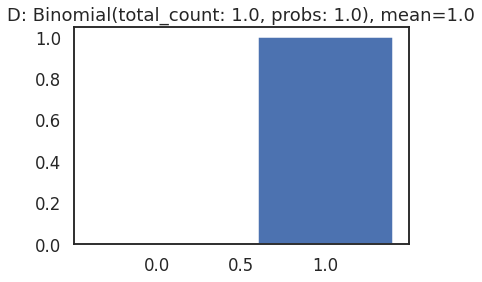

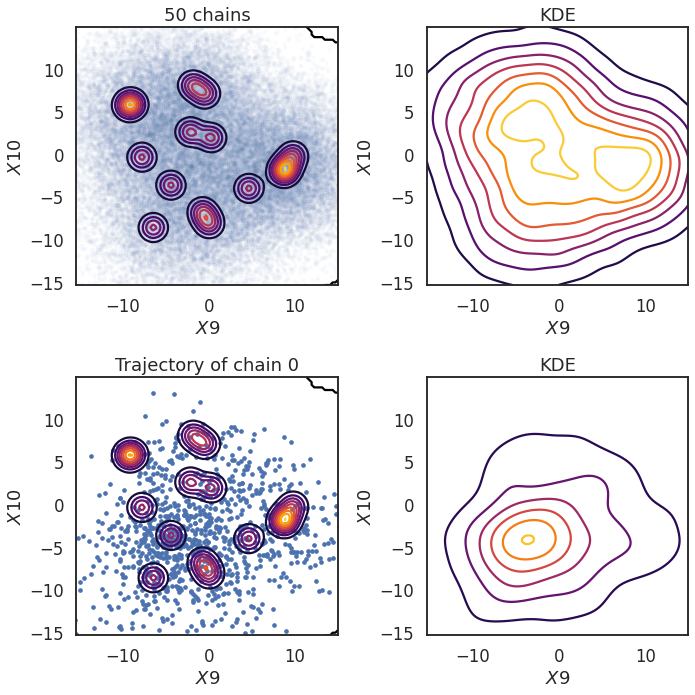

(8.8, 0.008, 0.2, 24.45)

In [416]:
run_exp(D.Binomial(probs=1), step_size=1.9, name="Const", verbose=True)

In [316]:
result_df = pd.DataFrame.from_dict(results)
result_df

,distribution,params,step_size,modes_covered,ess,sliced_TV,emd
0,const,,0.1,1.00,0.010,0.503,40.21
1,const,,0.1,1.00,0.006,0.502,39.49
2,const,,0.2,1.00,0.008,0.515,40.30
3,const,,0.3,1.00,0.006,0.511,39.80
4,const,,0.4,1.00,0.008,0.495,40.16
...,...,...,...,...,...,...,...
106,Beta,"a: 3.0, b: 9.0",0.8,1.02,0.002,0.483,39.05
107,Beta,"a: 3.0, b: 9.0",1.0,1.14,0.001,0.427,37.47
108,Beta,"a: 3.0, b: 9.0",1.2,2.46,0.001,0.327,32.02
109,Beta,"a: 3.0, b: 9.0",1.4,6.80,0.004,0.205,24.09


In [ ]:
result_df.sort_values(by="sliced_TV", axis=0).head(20)

In [322]:
result_df.sort_values(by="sliced_TV", axis=0).head(20)

,distribution,params,step_size,modes_covered,ess,sliced_TV,emd
92,Beta,"a: 3.0, b: 3.0",1.6,8.82,0.007,0.145,15.53
30,Beta,"a: 1.0, b: 3.0",1.2,10.08,0.012,0.147,16.52
48,Beta,"a: 1.0, b: 9.0",1.2,11.46,0.019,0.150,18.73
98,Beta,"a: 3.0, b: 5.0",1.6,10.34,0.013,0.153,16.38
110,Beta,"a: 3.0, b: 9.0",1.6,11.02,0.015,0.155,19.34
79,Beta,"a: 2.0, b: 9.0",1.4,10.32,0.012,0.158,18.17
56,Beta,"a: 2.0, b: 1.0",1.6,7.28,0.006,0.161,18.81
73,Beta,"a: 2.0, b: 7.0",1.4,10.14,0.020,0.161,19.86
74,Beta,"a: 2.0, b: 7.0",1.6,12.42,-0.523,0.165,22.85
42,Beta,"a: 1.0, b: 7.0",1.2,11.08,0.014,0.167,23.83


In [330]:
for a in np.linspace(4, 5, 2):
    for b in np.linspace(1, 9, 5):
        for step_size in np.linspace(0.6, 1.6, 6):
            modes, ess, tv, emd = run_exp(D.beta.Beta(a, b), step_size=step_size, name="Beta")
            results.append({
                "distribution" : "Beta",
                "params" : f"a: {a}, b: {b}",
                "step_size" : step_size,
                "modes_covered" : modes,
                "ess": ess,
                "sliced_TV" : tv,
                "emd" : emd,
            })

In [321]:
result_df.sort_values(by="emd", axis=0).head(20)

,distribution,params,step_size,modes_covered,ess,sliced_TV,emd
92,Beta,"a: 3.0, b: 3.0",1.6,8.82,0.007,0.145,15.53
98,Beta,"a: 3.0, b: 5.0",1.6,10.34,0.013,0.153,16.38
30,Beta,"a: 1.0, b: 3.0",1.2,10.08,0.012,0.147,16.52
79,Beta,"a: 2.0, b: 9.0",1.4,10.32,0.012,0.158,18.17
48,Beta,"a: 1.0, b: 9.0",1.2,11.46,0.019,0.150,18.73
56,Beta,"a: 2.0, b: 1.0",1.6,7.28,0.006,0.161,18.81
110,Beta,"a: 3.0, b: 9.0",1.6,11.02,0.015,0.155,19.34
73,Beta,"a: 2.0, b: 7.0",1.4,10.14,0.020,0.161,19.86
47,Beta,"a: 1.0, b: 9.0",1.0,7.14,0.005,0.174,20.59
104,Beta,"a: 3.0, b: 7.0",1.6,11.10,0.020,0.169,21.84


In [ ]:
# for a in np.linspace(0.2, 1, 5):
#     for b in np.linspace(0.2, 1, 5):
#         for step_size in  np.linspace(0.5, 1.3, 5):
#             modes, ess, tv, emd = run_exp(D.beta.Beta(a, b), step_size=step_size, name="Beta")
#             results.append({
#                 "distribution" : "Beta",
#                 "params" : f"a: {a}, b: {b}",
#                 "step_size" : step_size,
#                 "modes_covered" : modes,
#                 "ess": ess,
#                 "sliced_TV" : tv,
#                 "emd" : emd,
#             })

In [377]:
for k in np.linspace(1, 5, 5):
    for step_size in np.linspace(0.6, 1.8, 7):
        try:
            modes, ess, tv, emd = run_exp(D.chi2.Chi2(k), step_size=step_size, name="Chi Squared")
            results.append({
                "distribution" : "Chi2",
                "params" : f"k: {k}",
                "step_size" : step_size,
                "modes_covered" : modes,
                "ess": ess,
                "sliced_TV" : tv,
                "emd" : emd,
            })
        except ValueError:
            print(f"Error at k={k}, step_size={step_size}")

Error at k=1.0, step_size=1.6
Error at k=1.0, step_size=1.8
Error at k=2.0, step_size=1.8


In [ ]:
results_df

In [371]:
for a in np.linspace(0.5, 10, 20):
    for step_size in  np.linspace(0.6, 1.6, 6):
        modes, ess, tv, emd = run_exp(D.exponential.Exponential(a), step_size=step_size, name="Exponential")
        results.append({
            "distribution" : "Exponential",
            "params" : f"lambda: {a}",
            "step_size" : step_size,
            "modes_covered" : modes,
            "ess": ess,
            "sliced_TV" : tv,
            "emd" : emd,
        })

In [399]:
results

[{'distribution': 'const',
  'params': '',
  'step_size': 0.1,
  'modes_covered': 1.0,
  'ess': 0.01,
  'sliced_TV': 0.503,
  'emd': 40.21},
 {'distribution': 'const',
  'params': '',
  'step_size': 0.1,
  'modes_covered': 1.0,
  'ess': 0.006,
  'sliced_TV': 0.502,
  'emd': 39.49},
 {'distribution': 'const',
  'params': '',
  'step_size': 0.2,
  'modes_covered': 1.0,
  'ess': 0.008,
  'sliced_TV': 0.515,
  'emd': 40.3},
 {'distribution': 'const',
  'params': '',
  'step_size': 0.3,
  'modes_covered': 1.0,
  'ess': 0.006,
  'sliced_TV': 0.511,
  'emd': 39.8},
 {'distribution': 'const',
  'params': '',
  'step_size': 0.4,
  'modes_covered': 1.0,
  'ess': 0.008,
  'sliced_TV': 0.495,
  'emd': 40.16},
 {'distribution': 'const',
  'params': '',
  'step_size': 0.5,
  'modes_covered': 1.0,
  'ess': 0.012,
  'sliced_TV': 0.498,
  'emd': 39.58},
 {'distribution': 'const',
  'params': '',
  'step_size': 0.6,
  'modes_covered': 1.0,
  'ess': 0.006,
  'sliced_TV': 0.49,
  'emd': 39.36},
 {'distrib

In [ ]:
for mu in np.linspace(3, 7, 5):
    for sigma in np.linspace(0.5, 2, 4):
        distr = D.Normal(mu, sigma)
        for step_size in  np.linspace(0.6, 1.8, 7):
            try:
                modes, ess, tv, emd = run_exp(distr, step_size=step_size, name="Normal")
                results.append({
                    "distribution" : "Normal",
                    "params" : f"mu: {mu}, sigma: {sigma}",
                    "step_size" : step_size,
                    "modes_covered" : modes,
                    "ess": ess,
                    "sliced_TV" : tv,
                    "emd" : emd,
                })
            except ValueError:
                print(f"Error at mu={mu}, sigma={sigma}, step_size={step_size}")
                print(f"Error at mu={mu}, sigma={sigma}, step_size={step_size}")

In [408]:
result_df.to_csv("results.csv")

In [402]:
result_df = pd.DataFrame.from_dict(results)
result_df.sort_values(by="emd", axis=0).head(20)

,distribution,params,step_size,modes_covered,ess,sliced_TV,emd
92,Beta,"a: 3.0, b: 3.0",1.6,8.82,0.007,0.145,15.53
98,Beta,"a: 3.0, b: 5.0",1.6,10.34,0.013,0.153,16.38
30,Beta,"a: 1.0, b: 3.0",1.2,10.08,0.012,0.147,16.52
327,Chi2,k: 5.0,1.4,10.18,0.012,0.149,17.68
281,Exponential,lambda: 9.5,1.0,9.12,0.009,0.152,17.78
140,Beta,"a: 4.0, b: 9.0",1.6,9.86,0.010,0.160,17.99
79,Beta,"a: 2.0, b: 9.0",1.4,10.32,0.012,0.158,18.17
48,Beta,"a: 1.0, b: 9.0",1.2,11.46,0.019,0.150,18.73
56,Beta,"a: 2.0, b: 1.0",1.6,7.28,0.006,0.161,18.81
179,Exponential,lambda: 1.0,1.0,8.66,0.008,0.168,19.14


In [410]:
result_df.sort_values(by="modes_covered", axis=0).head(20)

,distribution,params,step_size,modes_covered,ess,sliced_TV,emd
350,Normal,"mu: 5.0, sigma: 0.5",1.8,0.00,0.002,0.210,27.17
343,Normal,"mu: 4.0, sigma: 0.5",1.8,0.00,0.003,0.198,26.39
20,const,,2.0,0.00,-0.589,0.332,90.84
379,Normal,"mu: 7.0, sigma: 0.5",1.8,0.00,0.002,0.242,30.49
364,Normal,"mu: 6.0, sigma: 0.5",1.8,0.00,0.002,0.191,21.56
336,Normal,"mu: 3.0, sigma: 0.5",1.8,0.00,0.006,0.177,23.40
19,const,,1.9,0.08,0.008,0.202,25.76
363,Normal,"mu: 6.0, sigma: 0.5",1.6,0.44,0.001,0.375,36.61
378,Normal,"mu: 7.0, sigma: 0.5",1.6,0.62,0.005,0.386,37.19
349,Normal,"mu: 5.0, sigma: 0.5",1.6,0.78,0.001,0.377,37.39


In [403]:
result_df.sort_values(by="sliced_TV", axis=0).head(20)

,distribution,params,step_size,modes_covered,ess,sliced_TV,emd
92,Beta,"a: 3.0, b: 3.0",1.6,8.82,0.007,0.145,15.53
30,Beta,"a: 1.0, b: 3.0",1.2,10.08,0.012,0.147,16.52
257,Exponential,lambda: 7.5,1.0,8.54,0.008,0.149,19.29
327,Chi2,k: 5.0,1.4,10.18,0.012,0.149,17.68
270,Exponential,lambda: 8.5,1.2,11.34,0.050,0.150,22.52
48,Beta,"a: 1.0, b: 9.0",1.2,11.46,0.019,0.150,18.73
281,Exponential,lambda: 9.5,1.0,9.12,0.009,0.152,17.78
98,Beta,"a: 3.0, b: 5.0",1.6,10.34,0.013,0.153,16.38
252,Exponential,lambda: 7.0,1.2,11.66,-0.003,0.154,23.60
246,Exponential,lambda: 6.5,1.2,11.84,1.403,0.154,21.90


  0%|          | 0/1050 [00:00<?, ?it/s]

Modes covered: 10.62 / 15
ESS: 0.012
Sliced TV: 0.148 ± 0.009
EMD: 17.897605968780486 ± 1.82


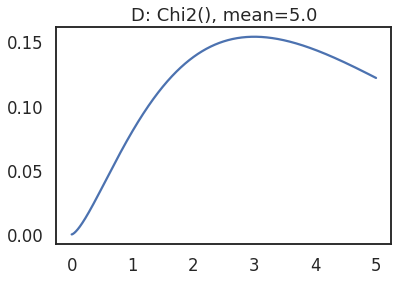

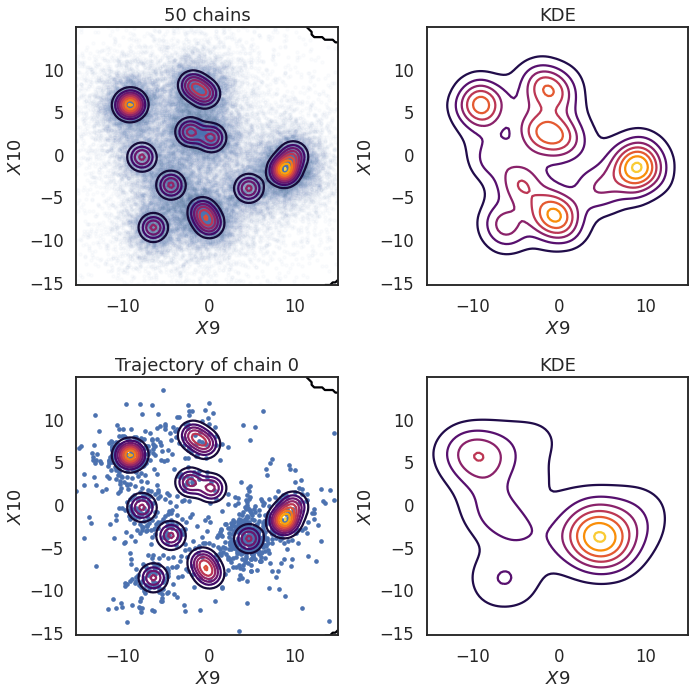

(10.62, 0.012, 0.148, 17.9)

In [409]:
run_exp(D.Chi2(5), step_size=1.4, name="Chi2", verbose=True)

In [ ]:
run_exp(D.Chi2(5), step_size=1.4, name="Chi2", verbose=True)

  0%|          | 0/1050 [00:00<?, ?it/s]

Modes covered: 11.52 / 15
ESS: 0.093
Sliced TV: 0.217 ± 0.059
EMD: 242.9052571009825 ± 375.82


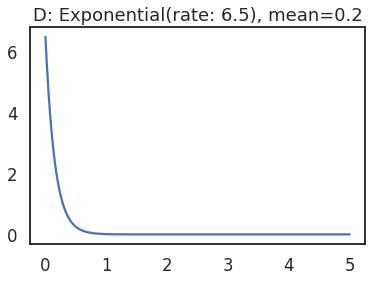

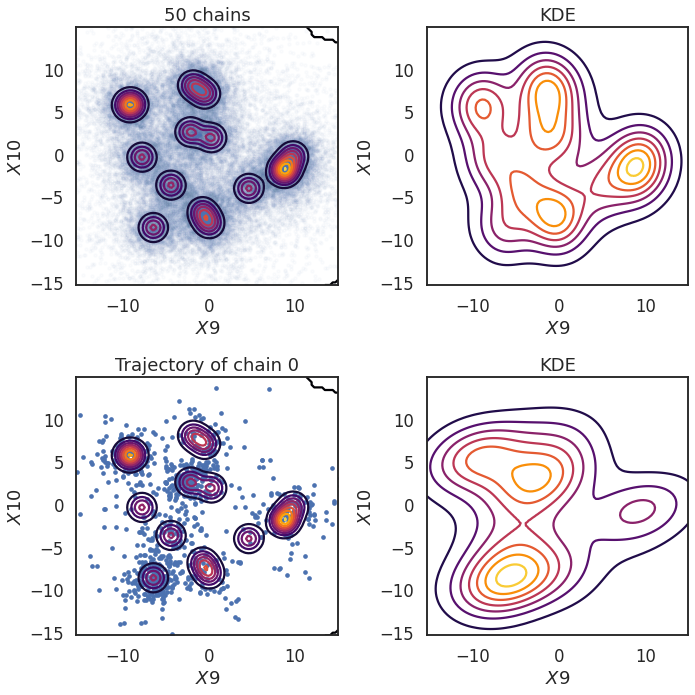

(11.52, 0.093, 0.217, 242.91)

In [395]:
run_exp(D.Exponential(6.5), step_size=1.2, name="Exp", verbose=True)

  0%|          | 0/1050 [00:00<?, ?it/s]

Modes covered: 9.08 / 15
ESS: 0.009
Sliced TV: 0.167 ± 0.014
EMD: 22.66354577575679 ± 2.59


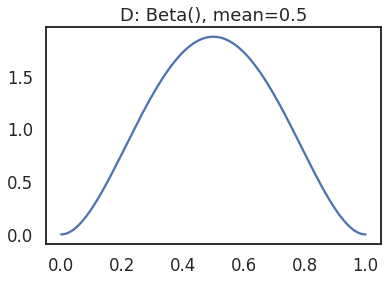

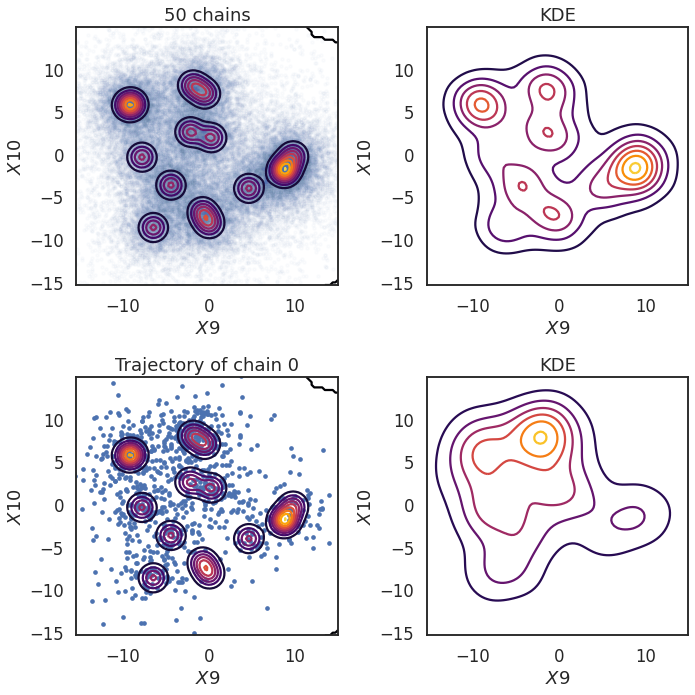

(9.08, 0.009, 0.167, 22.66)

In [388]:
run_exp(D.beta.Beta(3, 3), step_size=1.6, name="Beta", verbose=True)

In [407]:
np.save("results.npy", results)

# Distrs


$f(x_1, x_2, \cdots, x_d) = \left[\prod\limits_{i=1}^{d-1} \mathcal{N}(x_i \mid 0, e^{x_d / 2}) \right] \times \mathcal{N}(x_d \mid 0, a)$

“Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

Next example: $d$-dimensional Funnel distribution. Note that it allows for the reparametrisation, that allows for exact sampling. The  corresponding density function:
$$
p_{f}(x) = \operatorname{Z}^{-1} \exp\left(- x_d^2/2a^2 - (1/2) e^{-x_d} \sum\nolimits_{i=1}^{d-1}\{x_i^2 + x_1\}\right)\,, \quad d \geq 2,
$$
Note that we have a doule exponent in the density...

In [ ]:
class Funnel(object):
    """
    Funnel distribution.

    “Slice sampling”. R. Neal, Annals of statistics, 705 (2003) https://doi.org/10.1214/aos/1056562461

    Args:
        dim - dimension
        nu - parameter
    """
    def __init__(self, dim: int, a: float=3):
        self._dim = dim
        self.a = a
        self.normal_last = Normal(0, a)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        normal_first = Normal(torch.zeros(x.shape[:-1]), torch.exp(x[..., -1] / 2.))
        return normal_first.log_prob(x[..., :-1].permute(-1, *range(x.ndim-1))).sum(0) + \
            self.normal_last.log_prob(x[..., -1])

    def plot_2d_countour(self, ax):
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-7, 7, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])

        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=7, 
                   alpha=1., cmap='inferno')

In [ ]:
#default parameter
funnel_a = 2
dim_f = 10

funnel = Funnel(dim_f, funnel_a)
plt.figure(figsize = (8,8))
ax = plt.subplot()
funnel.plot_2d_countour(ax)

start_funnel = torch.randn((N_CHAINS, funnel.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_funnel[:, proj_slice].T, s=10, label='starting points')
plt.title('Funnel')
plt.legend()
plt.axis('equal')
plt.show()

Generate funnel with explicit reparametrization

In [ ]:
N_samples = 1*10**3
np.random.seed(42)
True_samples_f = np.random.randn(N_samples,dim)
True_samples_f[:,-1] *= funnel_a 
for k in range(dim-1):
    True_samples_f[:,k] *= np.exp(True_samples_f[:,-1]/2) 
#visualize funnel  
plt.figure(figsize = (8,8))
ax = plt.subplot()

proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(True_samples_f[:, -2],True_samples_f[:, -1], s=10, label='sample')
plt.title('Ground-truth funnel samples', fontsize = 16)
#plt.axis('equal')
plt.legend()
plt.show()

Next potential - Banana-shape distribution. It has somehow simpler geometry, compared to the Funnel. The density function:
$$
p_{b}(x) = Z^{-1} \exp\left(- \sum\nolimits_{i=1}^{d/2}\bigl\{x_{2i}^2/2a^2 - (x_{2i-1} - bx_{2i}^{2} + a^2 b)^{2}/2 \bigr\}\right)\,, \quad d = 2k, k \in \mathbb{N}
$$

In [ ]:
class Banana(object):
    """
    """
    def __init__(self, dim: int, b: float, sigma: float):
        #self.q = q
        self.b = b
        self.sigma = sigma
        self._dim = dim
        #self.normal_even = Normal(1, 1)
        #self.normal_odd = Normal(0, q)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        even = np.arange(0, x.shape[-1], 2)
        odd = np.arange(1, x.shape[-1], 2)
        ll = -0.5*(x[..., odd] - self.b*x[..., even]**2 + (self.sigma**2)*self.b)**2 - ((x[..., even])**2)/(2*self.sigma**2)
        return ll.sum(-1)

        #return self.normal_even.log_prob(x[..., even]).sum(-1) + \
        #    self.normal_odd.log_prob(x[..., even] - x[..., odd] ** 2).sum(-1)

    def plot_2d_countour(self, ax):
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-3, 3, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=5,
                   alpha=1., cmap='inferno')

In [ ]:
sigma_b = 5.0
banana_b = 0.05
dim_b = 10

banana = Banana(dim_b, banana_b, sigma_b)
ax = plt.subplot()
banana.plot_2d_countour(ax)

start_banana = torch.randn((N_CHAINS, banana.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_banana[:, proj_slice].T, s=10, label='starting points')
plt.title('Banana')
plt.legend()
plt.axis('equal')
plt.show()

Ground-truth samples from the banana-shape distibution with explicit reparametrization:


In [ ]:
N_samples = 10**3
np.random.seed(42)
True_samples_banana = np.random.randn(N_samples,dim_b)
for i in range(dim_b):
    if i % 2 == 0:
      True_samples_banana[:,i] *= sigma_b
    else:
      True_samples_banana[:,i] += banana_b*True_samples_banana[:,i-1]**2 - (sigma_b**2)*banana_b
#visualize banana  
plt.figure(figsize = (8,8))
ax = plt.subplot()
#mog.plot_2d_countour(ax)

#start_mog = torch.randn((N_CHAINS, mog.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(True_samples_banana[:, -2],True_samples_banana[:, -1], s=10, label='sample')
plt.title('Ground-truth banana samples', fontsize = 16)
plt.axis('equal')
plt.legend()
plt.show()

Utils to visualize samples

In [ ]:
# some code for drawing

def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    #get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    #EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(( (series[n] - sma) * multiplier) + sma)

    #now calculate the rest of the values
    for i in series[n+1:]:
        tmp = ( (i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

def plot_result(chains, dist, chain_id=0):
    proj_slice = [PROJ_DIM1, PROJ_DIM2]
    proj_dim1 = dist.dim + PROJ_DIM1 + 1 if PROJ_DIM1 < 0 else PROJ_DIM1 + 1
    proj_dim2 = dist.dim + PROJ_DIM2 + 1 if PROJ_DIM2 < 0 else PROJ_DIM2 + 1

    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    result = chains.reshape(-1, chains.shape[-1])
    dist.plot_2d_countour(axs[0,0])
    xmin, xmax = axs[0,0].get_xlim()
    ymin, ymax = axs[0,0].get_ylim()

    axs[0,0].scatter(*result[:, proj_slice].T, alpha=min(0.6, 1000./result.shape[0]), s=10)
    axs[0,0].set_title(f'Projected samples from {N_CHAINS} chains')

    kernel = gaussian_kde(result[:, proj_slice].T)
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde = np.reshape(kernel(positions).T, X.shape)
    axs[0,1].contour(X, Y, kde, cmap='inferno')
    axs[0,1].set_title(f'KDE')

    chain_id = 0
    result = chains[:, chain_id, :]
    dist.plot_2d_countour(axs[1,0])
    axs[1,0].scatter(*result[:, proj_slice].T, s = 10)
    axs[1,0].set_title(f'Trajectory of chain {chain_id}')

    if len(np.unique(result[:, proj_slice], axis=0)) > 0:
      try:
        kernel = gaussian_kde(np.unique(result[:, proj_slice], axis=0).T)
        x = np.linspace(xmin, xmax, 100)
        y = np.linspace(ymin, ymax, 100)
        X, Y = np.meshgrid(x, y)
        positions = np.vstack([X.ravel(), Y.ravel()])
        kde = np.reshape(kernel(positions).T, X.shape)
        axs[1,1].contour(X, Y, kde, cmap='inferno')
        axs[1,1].set_title(f'KDE')
      except np.linalg.LinAlgError:
        pass


    for i in range(2):
      for j in range(2):
        axs[i,j].set_xlim(xmin, xmax)
        axs[i,j].set_ylim(ymin, ymax)
        axs[i,j].set_xlabel(fr'$X{proj_dim1}$')
        axs[i,j].set_ylabel(fr'$X{proj_dim2}$')
        # ax.axis('square')

    fig.tight_layout()
    plt.show()

Let us now switch to graadient-based MCMC. We begin with Unadjusted and Metropolis-adjusted langevin algorithms

# Other

In [ ]:
def MALA(start: torch.FloatTensor, 
        target, 
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float, 
        verbose: bool=False) -> Tuple[torch.FloatTensor, List]:
    """
    Metropolis-Adjusted Langevin Algorithm with Normal proposal

    Args:
        start - strating points of shape [n_chains, dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    std_normal = MNormal(torch.zeros(start.shape[-1]), torch.eye(start.shape[-1]))
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    grad_x = torch.autograd.grad(logp_x.sum(), x)[0]

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        noise =  torch.randn_like(x)
        y = x + step_size * grad_x + noise * (2 * step_size) ** .5

        logp_y = target.log_prob(y)
        grad_y = torch.autograd.grad(logp_y.sum(), y)[0]

        log_qyx = std_normal.log_prob(noise)
        log_qxy = std_normal.log_prob((x - y - step_size * grad_y) / (2 * step_size) ** .5)
        
        accept_prob = torch.clamp((logp_y + log_qxy - logp_x - log_qyx).exp(), max=1)
        mask = torch.rand_like(accept_prob) < accept_prob

        with torch.no_grad():
            x[mask, :] = y[mask, :]
            logp_x[mask] = logp_y[mask]
            grad_x[mask] = grad_y[mask]

        acceptance_rate.append(mask.float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [ ]:
plot_result(chains, mog)

In [ ]:
sigma_b = 5.0
banana_b = 0.05
dim_b = 20

banana = Banana(dim_b, banana_b, sigma_b)

#step size
step_size = 0.5 #try different ones: 0.05, 0.25, 1.0. For small step size try different sample sizes
chains = ULA(start_banana, banana, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

In [ ]:
plot_result(chains, banana)

In [ ]:
funnel_a = 2
dim_f = 20

funnel = Funnel(dim_f, funnel_a)
step_size = 0.2 #try different step sizes: 0.01, 0.1, 0.2 
chains = ULA(start_funnel, funnel, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

In [ ]:
plot_result(chains, funnel)

As far as we have seen, ULA is not super good in sampling multimodal and highly-nonlinear densities. Let us try its corrected version (MALA).

In [ ]:
dim = 10
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)


#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

#tune step-size
step_size = 2 #try different ones: 0.05, 0.5, 1.0, 2.0

chains, acceptance_rates = MALA(start_mog, mog, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [ ]:
plot_result(chains, mog)

Optimal acceptance rate for MALA is known to be $~0.234$. Typically values between $0.2$ and $0.5$ are good.

In [ ]:
sigma_b = 5.0
banana_b = 0.05
dim_b = 20

banana = Banana(dim_b, banana_b, sigma_b)

#tune step-size
step_size = 1.0 #try different ones: 0.05, 0.25, 1.0

chains, acceptance_rates = MALA(start_banana, banana, 5*N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [ ]:
plot_result(chains, banana)

In [ ]:
funnel_a = 2
dim_f = 20

funnel = Funnel(dim_f, funnel_a)
step_size = 0.5 #try different step sizes: 0.01, 0.1, 0.5 

chains, acceptance_rates = MALA(start_funnel, funnel, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

In [ ]:
plt.plot(ema(acceptance_rates, 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')

In [ ]:
plot_result(chains, funnel)

Now let us try combining local and global moves, that is, Ex$^2$MCMC algorithm.

In [ ]:
def Ex2MCMC(start: torch.FloatTensor, 
        target,
        proposal,
        n_samples: int,
        burn_in: int,
        *, 
        step_size: float,
        n_particles: int, 
        n_mala_steps: int = 1,
        verbose: bool=False) -> Tuple[List[torch.FloatTensor], List]:
    """
    Ex2MCMC

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        proposal - proposal distribution instance with methods "log_prob" and "sample"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        n_particles - number of particles including one from previous step
        n_mala_steps - number of MALA steps after each SIR step
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """
    chains = []
    acceptance_rate = []
    
    x = start.clone()
    x.requires_grad_(True)
    x.grad = None
    logp_x = target.log_prob(x)
    logq_x = proposal.log_prob(x)

    range_ = trange if verbose else range
    for step_id in range_(n_samples + burn_in):
        particles = proposal.sample((x.shape[0], n_particles - 1))
        log_qs = torch.cat([logq_x[:, None], proposal.log_prob(particles)], 1)
        log_ps = torch.cat([logp_x[:, None], target.log_prob(particles)], 1)
        particles = torch.cat([x[:, None, :], particles], 1)

        log_weights = log_ps - log_qs
        indices = Categorical(logits=log_weights).sample()
        x = particles[np.arange(x.shape[0]), indices]

        if n_mala_steps > 0:
            xs, acc = MALA(x, target, n_mala_steps, 0, step_size=step_size)
            x = xs[-1]
            logp_x = target.log_prob(x)
            logq_x = proposal.log_prob(x)
        else:
            logp_x = log_ps[np.arange(x.shape[0]), indices]
            logq_x = log_qs[np.arange(x.shape[0]), indices]

        acceptance_rate.append((indices != 0).float().mean().item())
        if step_id >= burn_in:
            chains.append(x.detach().data.clone())
    chains = torch.stack(chains, 0)
    return chains, acceptance_rate

In [ ]:
dim = 20
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)


#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

step_size = 0.25
proposal_scale = 2.0
n_particles = 100
n_mala_steps = 3
proposal = MNormal(torch.zeros(mog.dim), torch.eye(mog.dim) * proposal_scale**2)


chains, acceptance_rates = Ex2MCMC(start_mog, mog, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

In [ ]:
plot_result(chains, mog)

In [ ]:
sigma_b = 5.0
banana_b = 0.05
dim_b = 20

banana = Banana(dim_b, banana_b, sigma_b)
start_banana = torch.randn((N_CHAINS, banana.dim))

step_size = 0.25
n_particles = 20
n_mala_steps = 3

#proposal parameters
proposal_covs = torch.ones(banana.dim)
even = np.arange(0, banana.dim, 2)
odd = np.arange(1, banana.dim, 2)
proposal_covs[even] *= sigma_b
proposal_covs[odd]*= (sigma_b**2)*banana_b*np.sqrt(2)
proposal_covs = torch.diag(proposal_covs)
#proposal distribution
proposal = MNormal(torch.zeros(banana.dim), proposal_covs)

chains, acceptance_rates = Ex2MCMC(start_banana, banana, proposal, N_SAMPLES, BURN_IN, 
    step_size=step_size, n_particles=n_particles, n_mala_steps=n_mala_steps, verbose=True)

In [ ]:
plot_result(chains, banana)

Now we will switch to HMC and its popular modifications (NUTS).

In [ ]:
def sample_HMC(start,
        target, 
        n_samples: int,
        burn_in: int, 
        *, 
        step_size: float,
        n_leap_steps: int,
        verbose: bool = False) -> torch.FloatTensor:
    """
    Hamiltonian Monte Carlo

    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        step_size - step size for drift term
        n_leap_steps - number of leapfrog steps
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = HMC(
        potential_fn=energy, step_size=step_size, num_steps=n_leap_steps, full_mass=False
        )

    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true

In [ ]:
def sample_NUTS(start,
        target, 
        n_samples: int,
        burn_in: int, 
        *, 
        verbose: bool = False) -> torch.FloatTensor:
    """
    No U-turn sampler
    Args:
        start - strating points of shape [n_chains x dim]
        target - target distribution instance with method "log_prob"
        n_samples - number of last samples from each chain to return
        burn_in - number of first samples from each chain to throw away
        verbose - whether to show iterations' bar

    Returns:
        tensor of chains with shape [n_samples, n_chains, dim], acceptance rates for each iteration
    """

    x = start.clone()
    x.requires_grad_(False)
    def energy(z):
        z = z["points"]
        return -target.log_prob(z).sum()

    kernel = NUTS(potential_fn=energy, full_mass=False)
    init_params = {"points": x}
    mcmc_true = MCMC(
        kernel=kernel,
        num_samples=n_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()

    q_true = mcmc_true.get_samples(group_by_chain=True)["points"]
    samples_true = q_true.view(-1, *start.shape)

    return samples_true

In [ ]:
dim = 10
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)

#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

#hyperparameters for HMC
step_size = 0.1
n_leap_steps = 30 #choose different number of leap-frog steps: N = 5, 30, 50

chains = sample_HMC(start_mog, mog, N_SAMPLES, BURN_IN,
    step_size=step_size, n_leap_steps=n_leap_steps, verbose=True)

In [ ]:
plot_result(chains, mog)

In [ ]:
step_size = 0.1
n_leap_steps = 50 #choose different values: N = 5, 10, 50

chains = sample_HMC(start_banana, banana, N_SAMPLES, BURN_IN,
    step_size=step_size, n_leap_steps=n_leap_steps, verbose=True)

In [ ]:
plot_result(chains, banana)

In [ ]:
step_size = 0.1
n_leap_steps = 20 #try different ones: L = 10, 20, 50

chains = sample_HMC(start_funnel, funnel, N_SAMPLES, BURN_IN,
    step_size=step_size, n_leap_steps=n_leap_steps, verbose=True)

In [ ]:
plot_result(chains, funnel)

Now let us try NUTS - the HMC method with balanced strategy for fine-tuning stepsize $\varepsilon$ and the number of steps $L$

In [ ]:
dim = 2
center_pts = 4*(np.random.rand(4,dim)-0.5)

locs = torch.FloatTensor([center_pts[0,0:(dim-2)].tolist() + [-3,3], \
                          center_pts[1,0:(dim-2)].tolist() + [-3,-3], \
                          center_pts[2,0:(dim-2)].tolist()+[3,3], \
                          center_pts[3,0:(dim-2)].tolist()+[3,-3]])
covs = torch.eye(dim)[None, ...].repeat(4, 1, 1).float()
weights = torch.FloatTensor([1, 2, 1, 0.5])
mog = MoG(locs, covs, weights)
#create starting points
start_mog = torch.randn((N_CHAINS, mog.dim))

#hyperparameters for HMC
#finally no hyperparameters!

chains = sample_NUTS(start_mog, mog, N_SAMPLES, BURN_IN,verbose=True)

In [ ]:
plot_result(chains, mog)